In [23]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# helper functions

In [107]:
from pybiomart import Server

In [108]:
server = Server(host='http://www.ensembl.org')
mart = server['ENSEMBL_MART_ENSEMBL']
dataset = mart['hsapiens_gene_ensembl']

In [142]:
gene_id_map = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
transcript_id_map = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name', 'ensembl_transcript_id', 'external_transcript_name'])

In [143]:
gene_id_map.columns = ['gene_id', 'gene_symbol']
gene_id_map = gene_id_map[gene_id_map['gene_symbol'].notna()]
gene_id_map = gene_id_map.set_index('gene_id')
gene_id_map.head()

,gene_symbol
gene_id,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1


In [144]:
transcript_id_map.columns = ['gene_id', 'gene_symbol', 'transcript_id', 'transcript_symbol']
transcript_id_map = transcript_id_map[transcript_id_map['transcript_symbol'].notna()]
transcript_id_map = transcript_id_map.set_index('transcript_id')
transcript_id_map.head()

,gene_id,gene_symbol,transcript_symbol
transcript_id,,,
ENST00000387314,ENSG00000210049,MT-TF,MT-TF-201
ENST00000389680,ENSG00000211459,MT-RNR1,MT-RNR1-201
ENST00000387342,ENSG00000210077,MT-TV,MT-TV-201
ENST00000387347,ENSG00000210082,MT-RNR2,MT-RNR2-201
ENST00000386347,ENSG00000209082,MT-TL1,MT-TL1-201


In [145]:
def gene_to_symbol(gene_list):
    symbols = []
    clean = [x.split('.')[0] for x in gene_list]
    for y in clean:
        try:
            symbols.append(gene_id_map.loc[y]['gene_symbol'])
        except KeyError:
            symbols.append(y)
    return symbols

In [242]:
def transcript_to_symbol(transcript_list):
    symbols = []
    clean = [x.split('.')[0] for x in transcript_list]
    for y in clean:
        try:
            symbols.append(transcript_id_map.loc[y]['transcript_symbol'])
        except KeyError:
            symbols.append(y)
    return symbols

In [826]:
def transcript_to_gene(transcript_list):
    symbols = []
    clean = [x.split('.')[0] for x in transcript_list]
    for y in clean:
        try:
            symbols.append(transcript_id_map.loc[y]['gene_symbol'])
        except KeyError:
            symbols.append(y)
    return symbols

In [828]:
def tsymbol_to_gsymbol(transcript_list):
    symbols = []
    transcript_map = transcript_id_map.copy()
    transcript_map = transcript_map.reset_index()
    transcript_map = transcript_map.set_index('transcript_symbol')
    for x in transcript_list:
        try:
            gene_symbol = transcript_map.loc[x]['gene_symbol']
        except KeyError:
            gene_symbol = ''
        symbols.append(gene_symbol)
    return symbols

In [526]:
import seaborn as sns

def plot_contingency(adata, key1, key2):
    contingency = pd.crosstab(
    adata.obs[key1],  
    adata.obs[key2],
    normalize='columns')
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(contingency, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Proportion'})
    plt.xlabel(key2)
    plt.ylabel(key1)
    plt.title('Cluster Correspondence')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_volcano(plotting_df, title): 
    plt.figure(figsize=(4, 3))

    sig = 
    
    plt.scatter(x=plotting_df['log2fc'], y=plotting_df['p_val_adj'], c=plotting_df['color'], s=10, alpha=0.7)
    
    # 4. Add reference lines for significance and fold change
    plt.axhline(y=pval_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=log2fc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-log2fc_thresh, color='black', linestyle='--', linewidth=1)
    
    
    plt.xlabel('Log₂ Fold Change')
    plt.ylabel('-log 10 (p-value)')
    plt.title(title)
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

In [800]:
def plot_volcano(plotting_df, title): 
    plt.figure(figsize=(4, 3))
    plt.scatter(x=plotting_df['log2fc'], y=plotting_df['p_val_adj'], c=plotting_df['color'], s=10, alpha=0.7)
    
    # 4. Add reference lines for significance and fold change
    plt.axhline(y=pval_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=log2fc_thresh, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-log2fc_thresh, color='black', linestyle='--', linewidth=1)
    
    
    plt.xlabel('Log₂ Fold Change')
    plt.ylabel('-log 10 (p-value)')
    plt.title(title)
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.show()

In [799]:
# Define significance thresholds
pval_thresh = -np.log10(0.05)
log2fc_thresh = 1

def create_de_df(adata, cluster):
    # Access rank_genes_groups from adata
    results = adata.uns['rank_genes_groups']
    
    # Extract data for the specific cluster

    logfc = results['logfoldchanges'][cluster]
    pvals_adj = -np.log10(results['pvals_adj'][cluster])
    pvals = results['pvals'][cluster]
    genes = results['names'][cluster]
    
    
    plotting_df = pd.DataFrame({'gene': genes, 'log2fc': logfc, 'p_val_adj': pvals_adj, 'pval': pvals})
    
    #significant up/down (red/green) not significant (gray)
    plotting_df['color'] = 'gray' # Default color
    plotting_df.loc[(plotting_df['p_val_adj'] < pval_thresh) & (plotting_df['log2fc'] > log2fc_thresh), 'color'] = 'red'    # Upregulated
    plotting_df.loc[(plotting_df['p_val_adj'] < pval_thresh) & (plotting_df['log2fc'] < -log2fc_thresh), 'color'] = 'green' # Downregulated

    return plotting_df

# load datasets

In [1019]:
#load gene exp data
ad_lung_gene = sc.read_h5ad('mrVI_integrated_sc_sn_gene-exp.h5ad')
#load isoform exp data
ad_lung_iso = sc.read_h5ad('isoform_data_integrated.h5ad')

In [1020]:
ad_lung_gene, ad_lung_iso

(AnnData object with n_obs × n_vars = 15003 × 46294
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'cell_line', 'n_genes', '_scvi_batch', '_scvi_labels', '_indices', '_scvi_sample', 'leiden'
     var: 'n_cells'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_line_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
     obsm: 'X_mrVI', 'X_umap'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 15003 × 100589
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
     var: 'n_cells'
     uns: '

In [1021]:
# mean number of genes and isoforms per cell -- pretty ok

np.mean(ad_lung_gene.obs['n_genes_by_counts']), np.mean(ad_lung_iso.obs['n_genes_by_counts'])

(np.float64(5289.579084183163), np.float64(5460.405185629541))

In [1022]:
#convert gene/feature names - some have no conversion
ad_lung_gene.var_names = gene_to_symbol(ad_lung_gene.var_names)
ad_lung_gene.var_names[:10]

Index(['SNORD115-45', 'DMAC1P1', 'ENSG00000280234', 'IGHV3-33', 'IGHV4-34',
       'IGHV3-35', 'IGHV3-38', 'IGHV4-39', 'IGHV1-46', 'ENSG00000228757'],
      dtype='object')

In [1023]:
#convert transcript/feature names - some have no conversion
ad_lung_iso.var_names = transcript_to_symbol(ad_lung_iso.var_names)
ad_lung_iso.var_names[:10]

Index(['DDX11L16-258', 'CICP27-201', 'ENST00000496488', 'ENST00000669836',
       'ENST00000635159', 'ENST00000423796', 'MTND1P23-201', 'MTND2P28-201',
       'MTCO1P12-201', 'MTATP8P1-201'],
      dtype='object')

In [1024]:
ad_lung_gene.var_names_make_unique()
ad_lung_iso.var_names_make_unique()

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2']
  warnings.warn(


In [1025]:
# confirm the cell names match
pd.Series(ad_lung_gene.obs_names == ad_lung_iso.obs_names).value_counts()

True    15003
Name: count, dtype: int64

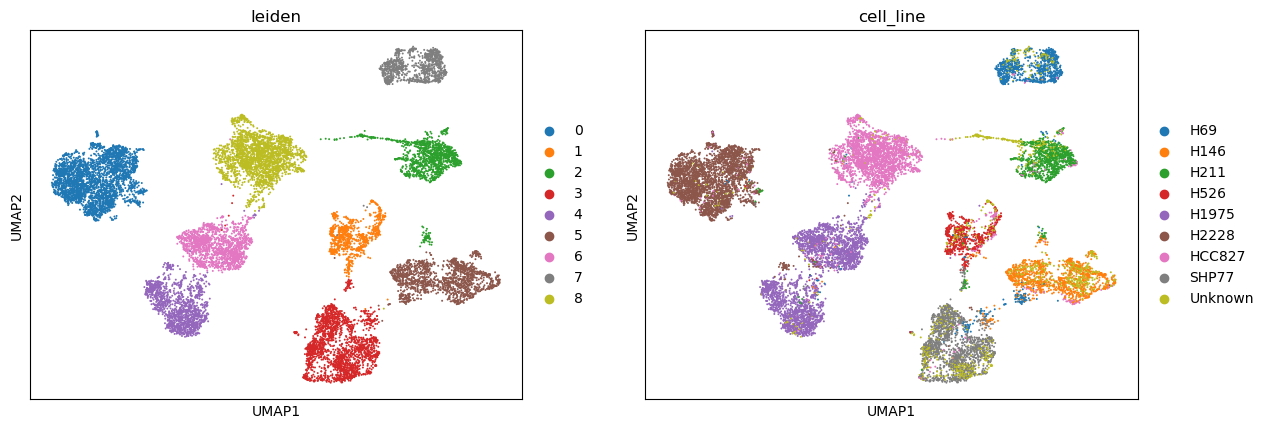

In [1026]:
sc.pl.umap(ad_lung_gene, color=['leiden', 'cell_line'])

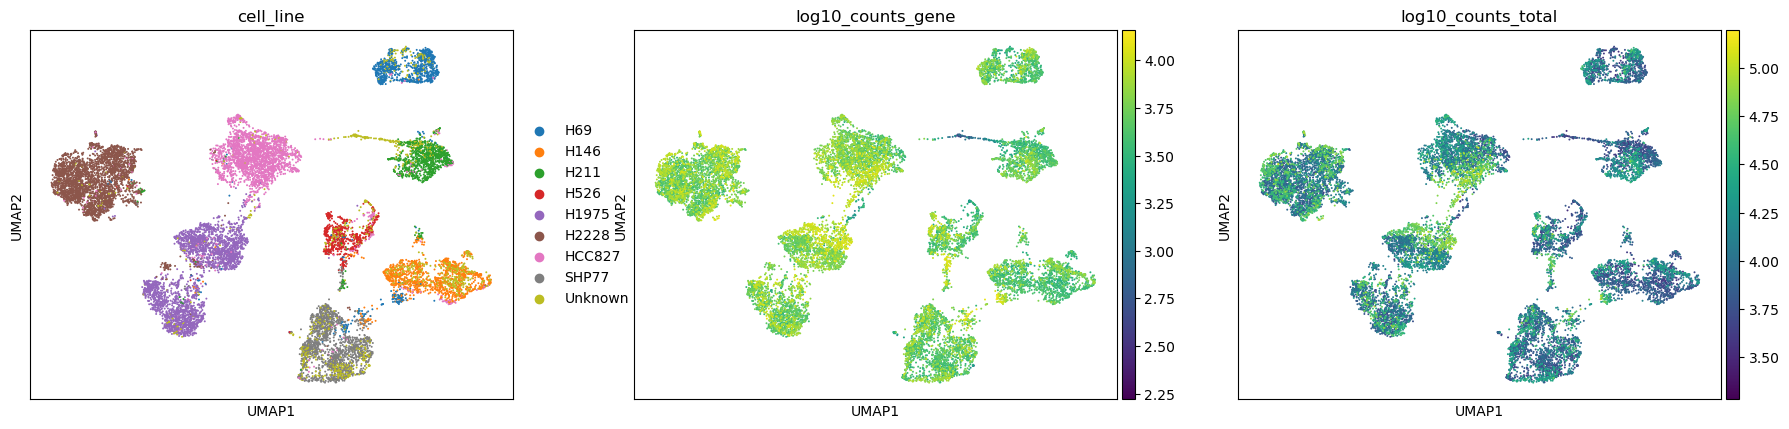

In [1027]:
#look at some quality metrics

ad_lung_gene.obs['log10_counts_gene'] = np.log10(ad_lung_gene.obs['n_genes_by_counts'])
ad_lung_gene.obs['log10_counts_total'] = np.log10(ad_lung_gene.obs['total_counts'])

ad_lung_iso.obs['log10_counts_gene'] = np.log10(ad_lung_iso.obs['n_genes_by_counts'])
ad_lung_iso.obs['log10_counts_total'] = np.log10(ad_lung_iso.obs['total_counts'])

sc.pl.umap(ad_lung_gene, color=['cell_line','log10_counts_gene', 'log10_counts_total'])

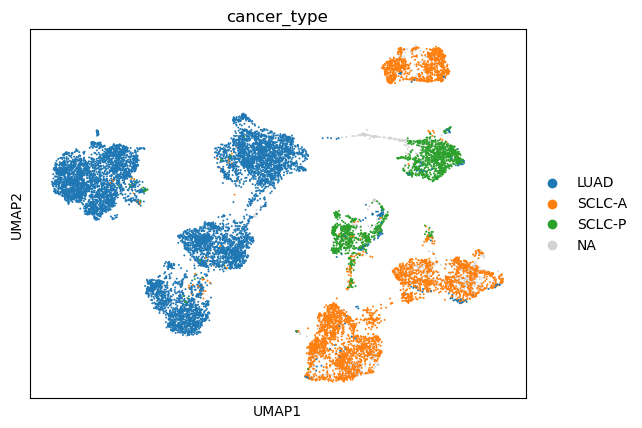

In [1028]:
#add a new label for the lung cancer type - might be useful later?

mapping = {"H1975":"LUAD", 
           "HCC827":"LUAD", 
           "H2228":"LUAD", 
           "H526":"SCLC-P", 
           "H211":"SCLC-P", 
           "SHP77":"SCLC-A", 
           "H146":"SCLC-A", 
           "H69":"SCLC-A" }

cell_line_labels = ad_lung_gene.obs['cell_line']
cancer_type = cell_line_labels.map(mapping)
ad_lung_gene.obs['cancer_type'] = cancer_type

sc.pl.umap(ad_lung_gene, color=['cancer_type'])

In [1029]:
# add these labels to the isoform anndata as well

ad_lung_iso.obs['cell_line'] = ad_lung_gene.obs['cell_line']
ad_lung_iso.obs['cancer_type'] = ad_lung_gene.obs['cancer_type']

# clustering (leiden)

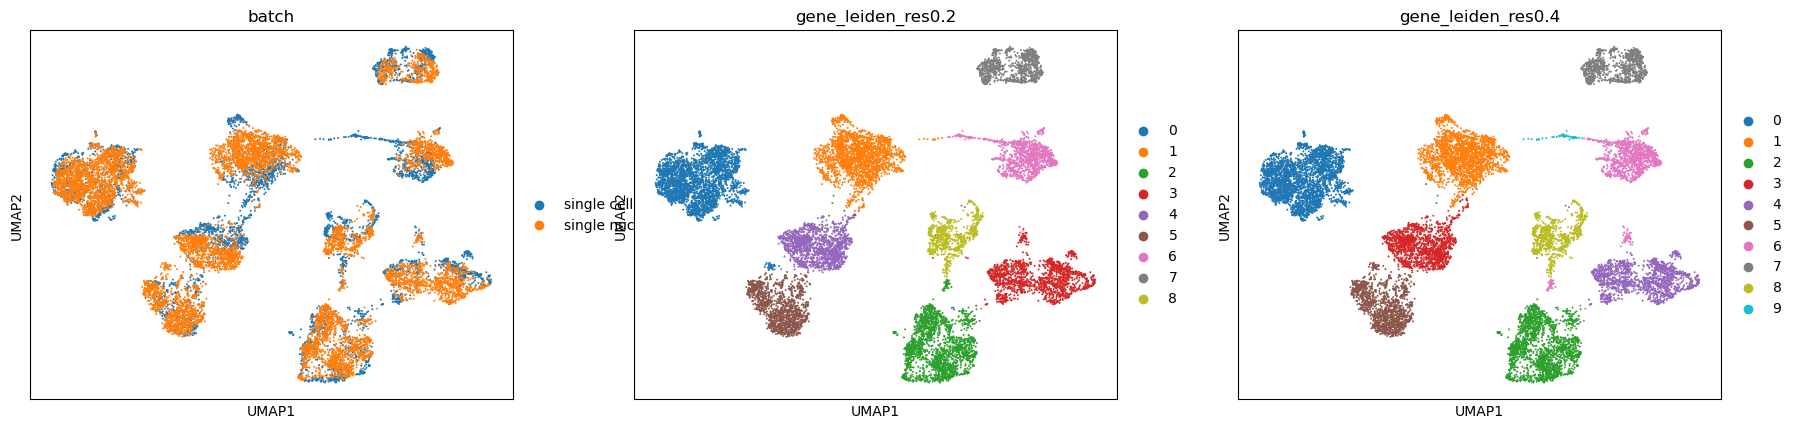

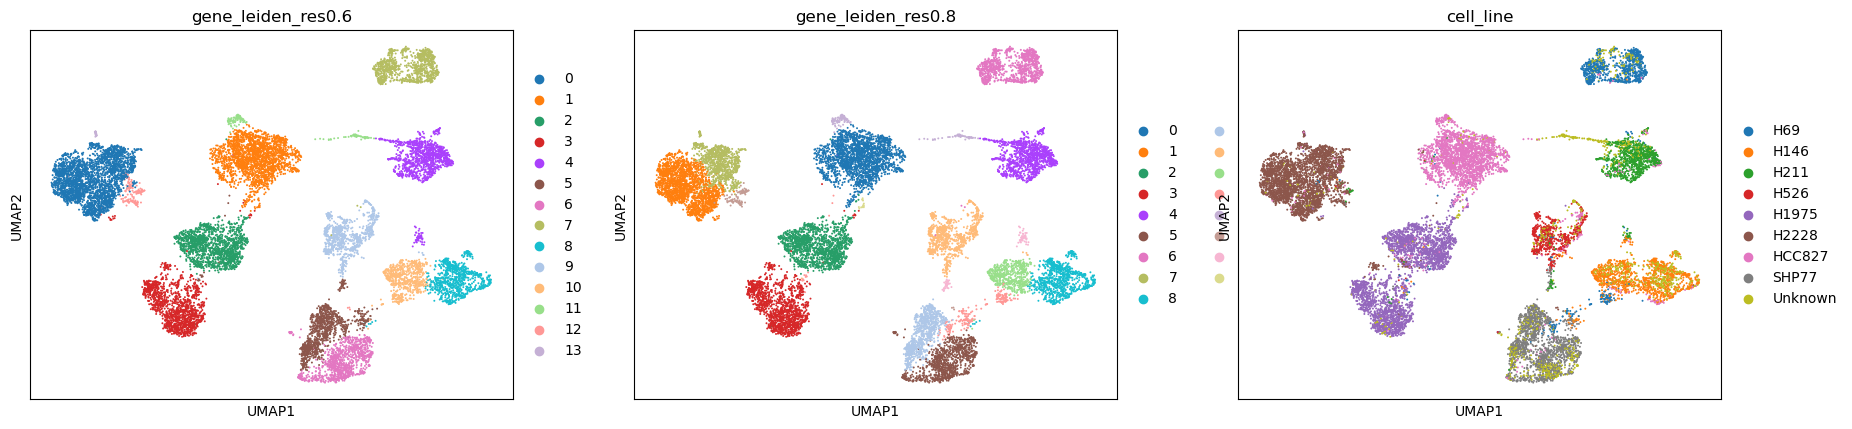

In [1030]:
# leiden clusters for gene expression...

for res in [0.2, 0.4, 0.6, 0.8, 1]:
    key = 'gene_leiden_res' + str(res)
    sc.tl.leiden(ad_lung_gene, resolution=res, key_added=key)

sc.pl.umap(ad_lung_gene, color=['batch', 'gene_leiden_res0.2', 'gene_leiden_res0.4'])
sc.pl.umap(ad_lung_gene, color=['gene_leiden_res0.6', 'gene_leiden_res0.8','cell_line'])


In [1033]:
sc.pp.neighbors(ad_lung_iso, use_rep='X_scVI')
sc.tl.umap(ad_lung_iso)

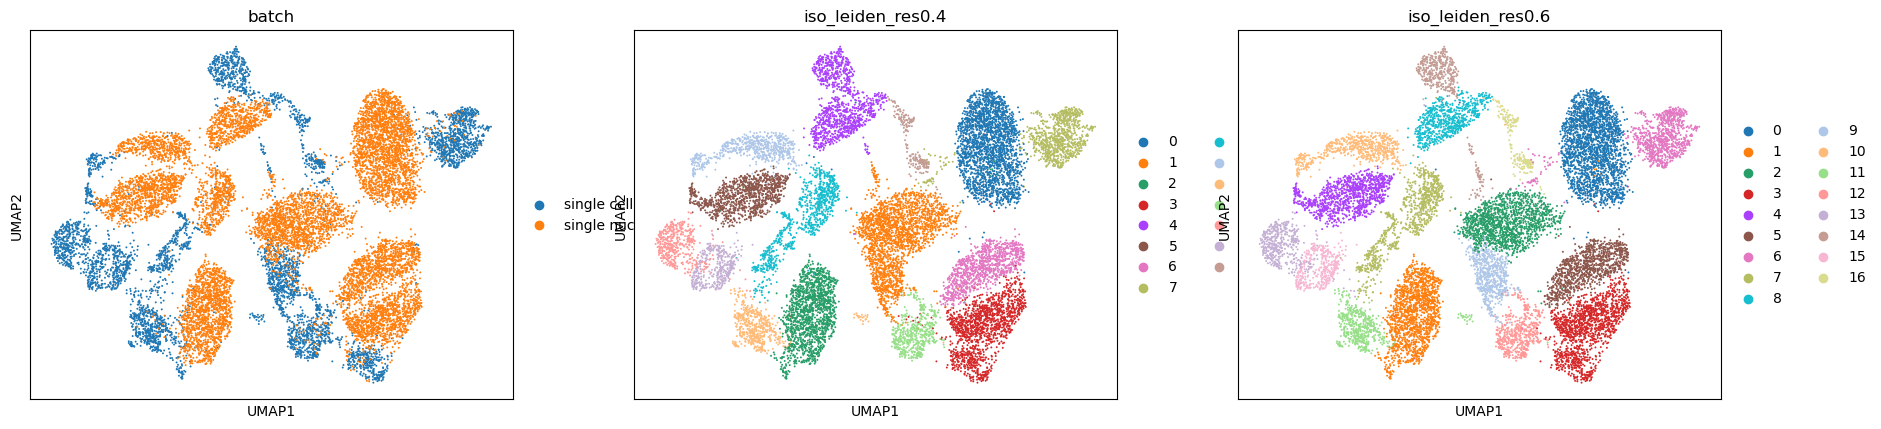

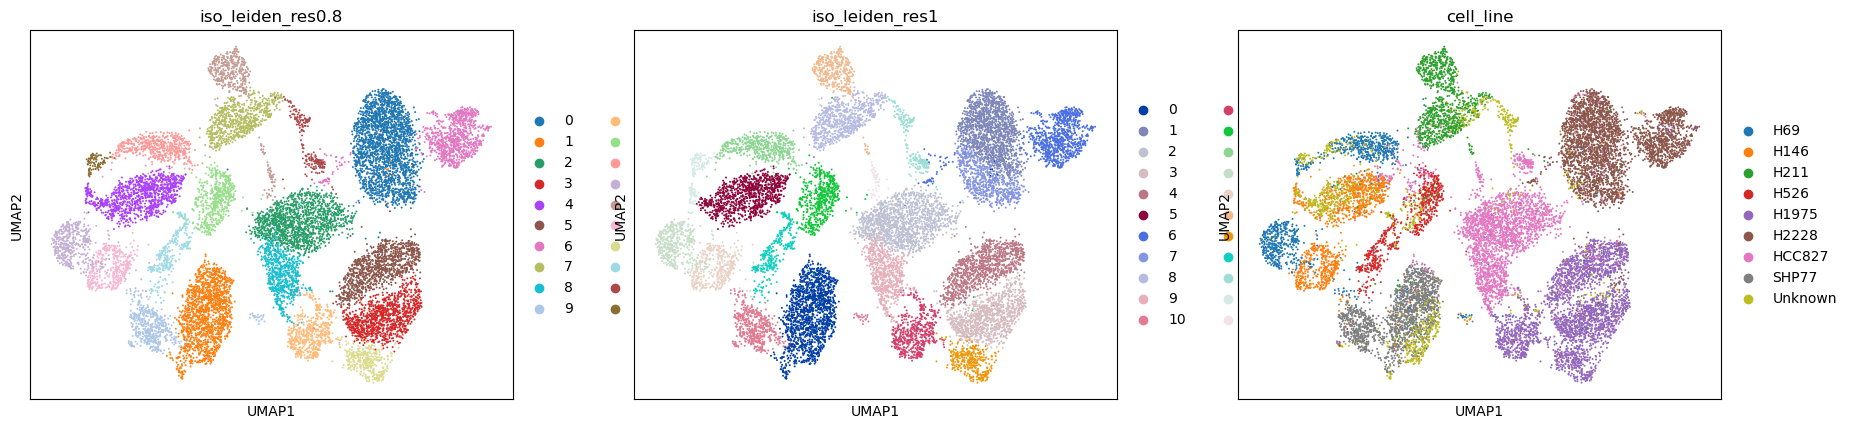

In [1034]:
# do the same for for isoform expression (leiden)

# leiden clusters for gene expression...

for res in  [0.2, 0.4, 0.6, 0.8, 1]:
    key = 'iso_leiden_res' + str(res)
    sc.tl.leiden(ad_lung_iso, resolution=res, key_added=key)

sc.pl.umap(ad_lung_iso, color=['batch', 'iso_leiden_res0.4', 'iso_leiden_res0.6'])
sc.pl.umap(ad_lung_iso, color=['iso_leiden_res0.8', 'iso_leiden_res1', 'cell_line'])


# silhoutte analysis

In [1035]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

Resolution 0.2: Silhouette Score = 0.210
Resolution 0.3: Silhouette Score = 0.210
Resolution 0.4: Silhouette Score = 0.208
Resolution 0.6: Silhouette Score = 0.148
Resolution 0.8: Silhouette Score = 0.130
Resolution 1.0: Silhouette Score = 0.106


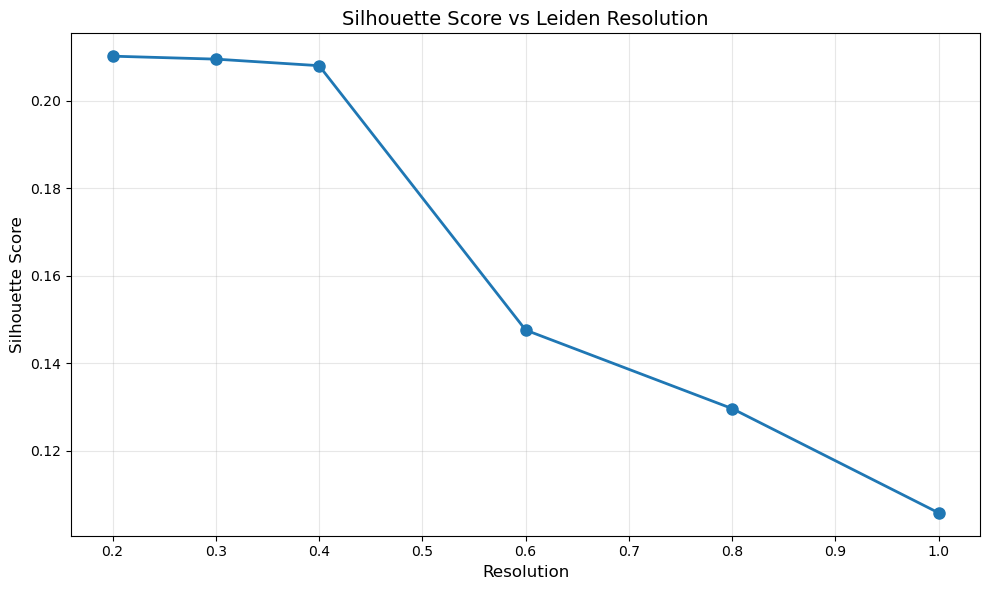


Best resolution: 0.2


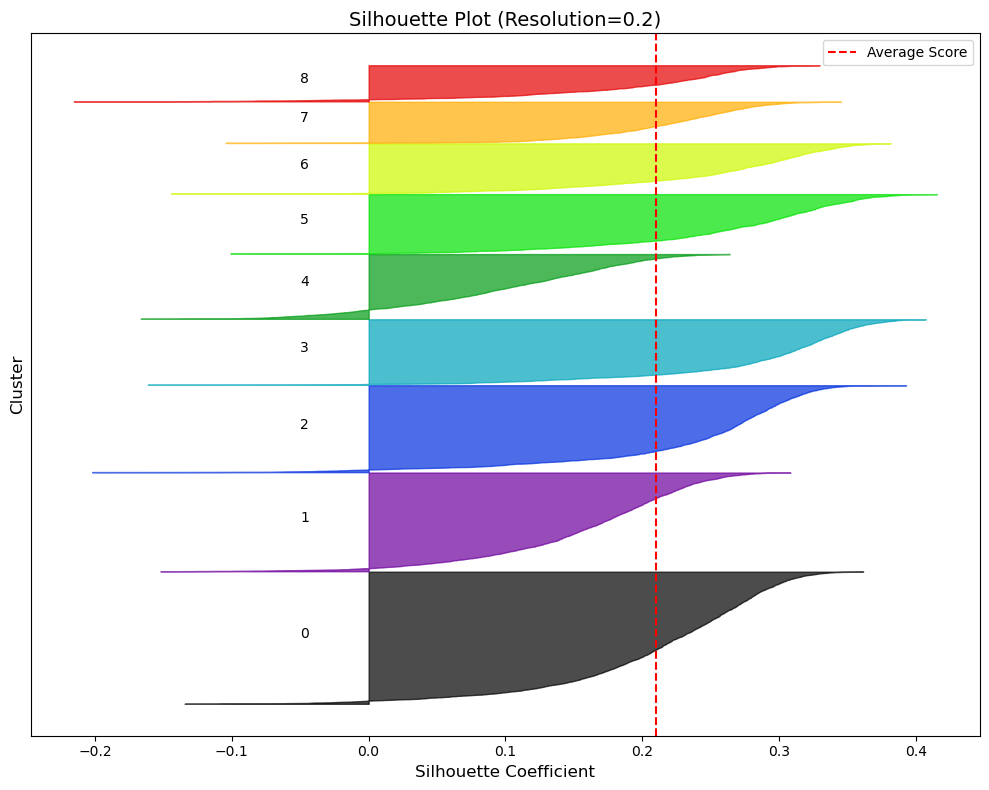

In [1036]:
resolutions = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
silhouette_scores = []

for res in resolutions:
    sc.tl.leiden(ad_lung_gene, resolution=res, key_added=f'gene_leiden_res{res}')
    # Calculate silhouette score using PCA representation
    score = silhouette_score(ad_lung_gene.obsm['X_mrVI'], ad_lung_gene.obs[f'gene_leiden_res{res}'].astype(int))
    silhouette_scores.append(score)
    print(f"Resolution {res}: Silhouette Score = {score:.3f}")

# Plot silhouette scores across resolutions
plt.figure(figsize=(10, 6))
plt.plot(resolutions, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Resolution', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Leiden Resolution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# For a detailed silhouette plot at a specific resolution (e.g., best one)
best_res = resolutions[np.argmax(silhouette_scores)]
print(f"\nBest resolution: {best_res}")

# Detailed silhouette plot for the best resolution
cluster_labels = ad_lung_gene.obs[f'gene_leiden_res{best_res}'].astype(int)
silhouette_vals = silhouette_samples(ad_lung_gene.obsm['X_mrVI'], cluster_labels)

# Create the silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10

n_clusters = len(np.unique(cluster_labels))
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title(f"Silhouette Plot (Resolution={best_res})", fontsize=14)
ax.axvline(x=silhouette_scores[np.argmax(silhouette_scores)], 
           color="red", linestyle="--", label=f"Average Score")
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
resolutions = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
silhouette_scores = []

for res in resolutions:
    sc.tl.leiden(ad_lung_iso, resolution=res, key_added=f'gene_leiden_res{res}')
    # Calculate silhouette score using PCA representation
    score = silhouette_score(ad_lung_iso.obsm['X_scVI'], ad_lung_iso.obs[f'gene_leiden_res{res}'].astype(int))
    silhouette_scores.append(score)
    print(f"Resolution {res}: Silhouette Score = {score:.3f}")

# Plot silhouette scores across resolutions
plt.figure(figsize=(10, 6))
plt.plot(resolutions, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Resolution', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Leiden Resolution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# For a detailed silhouette plot at a specific resolution (e.g., best one)
best_res = resolutions[np.argmax(silhouette_scores)]
print(f"\nBest resolution: {best_res}")

# Detailed silhouette plot for the best resolution
cluster_labels = ad_lung_iso.obs[f'gene_leiden_res{best_res}'].astype(int)
silhouette_vals = silhouette_samples(ad_lung_iso.obsm['X_scVI'], cluster_labels)

# Create the silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10

n_clusters = len(np.unique(cluster_labels))
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title(f"Silhouette Plot (Resolution={best_res})", fontsize=14)
ax.axvline(x=silhouette_scores[np.argmax(silhouette_scores)], 
           color="red", linestyle="--", label=f"Average Score")
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

Resolution 0.2: Silhouette Score = 0.128
Resolution 0.3: Silhouette Score = 0.128
Resolution 0.4: Silhouette Score = 0.136
Resolution 0.6: Silhouette Score = 0.139
Resolution 0.8: Silhouette Score = 0.128


In [ ]:
# from a silhoutte analysis (not in this notebook), we determined the ideal resolution for the gene exp clusters to be
# at 0.2 and the isoform exp clusters at 0.6

sc.pl.umap(ad_lung_gene, color=['batch', 'cell_line', 'gene_leiden_res0.2'])
sc.pl.umap(ad_lung_iso, color=['cell_line', 'iso_leiden_res0.6'])

In [ ]:
# one particular example are the isfoform sublclusters of cell line H1975
# that are not resolved in the leiden clustering for gene expression
sc.pl.umap(ad_lung_gene, color=['cell_line', 'gene_leiden_res0.2'])
sc.pl.umap(ad_lung_iso, color=['cell_line'])
sc.pl.umap(ad_lung_iso, color=['iso_leiden_res0.6'], groups=['3', '5', '12'])

# DE analysis for H1975 subclusters

In [ ]:
# logarithmize data for DE analysis
sc.pp.log1p(ad_lung_iso)

In [ ]:
# subset data for single nuclei and single cell
lung_iso_sn = ad_lung_iso[ad_lung_iso.obs['batch'] == 'single nuclei'].copy()
lung_iso_sc = ad_lung_iso[ad_lung_iso.obs['batch'] == 'single cell'].copy()

In [ ]:
# now do a DE on just the single nuclei
# excluded cluster 12 as there were very few cells in this subcluster

sc.tl.rank_genes_groups(lung_iso_sn, 'iso_leiden_res0.6', groups=['3', '5'], method='wilcoxon', n_genes=50000)

In [ ]:
cluster3_de = create_de_df(lung_iso_sn, '3')
cluster3_de.head()

In [ ]:
plot_volcano(cluster3_de, 'cluster 3')

In [ ]:
plot_volcano(cluster3_de.drop([x for x in range(3)]), 'cluster 3')

In [ ]:
cluster5_de = create_de_df(lung_iso_sn, '5')
cluster5_de.head()

In [ ]:
plot_volcano(cluster5_de, 'cluster 5')

In [ ]:
#filter for significance
cluster3_de = cluster3_de[cluster3_de.p_val_adj.apply(lambda x: x < -np.log10(0.05))]
cluster5_de = cluster5_de[cluster5_de.p_val_adj.apply(lambda x: x < -np.log10(0.05))]

# we dont want to look outliers fold change of > 20 for cluster 5
# and for cluster 3 fold changes > 20 and < -10
#filter for fold change outliers

cluster3_de = cluster3_de[cluster3_de.log2fc.apply(lambda x: (x < 10) and (x > -5))]
cluster3_de = cluster3_de[cluster3_de.log2fc.apply(lambda x: (x < 10))]

In [ ]:
up_cluster3 = cluster3_de.sort_values('log2fc', ascending=False)['gene'][:20].tolist()
down_cluster3 = cluster3_de.sort_values('log2fc', ascending=True)['gene'][:20].tolist()

up_cluster5 = cluster5_de.sort_values('log2fc', ascending=False)['gene'][:20].tolist()
down_cluster5 = cluster5_de.sort_values('log2fc', ascending=True)['gene'][:20].tolist()


In [ ]:
# convert the transcript symbols to gene symbols
up_cluster3 = tsymbol_to_gsymbol(up_cluster3)
up_cluster3

In [ ]:
down_cluster3 = tsymbol_to_gsymbol(down_cluster3)
down_cluster3

In [ ]:
up_cluster5 = tsymbol_to_gsymbol(up_cluster5)
up_cluster5

In [ ]:
down_cluster5 = tsymbol_to_gsymbol(down_cluster5)
down_cluster5

In [ ]:
# do the same for gene expression
# transfer over isoform cluster labels subset data for single nuclei 
ad_lung_gene.obs['leiden_from_iso'] = ad_lung_iso.obs['iso_leiden_res0.6']
lung_gene_sn = ad_lung_gene[ad_lung_gene.obs['batch'] == 'single nuclei'].copy()

In [ ]:
#sc.pp.log1p(lung_gene_sn)

In [ ]:
sc.tl.rank_genes_groups(lung_gene_sn, 'leiden_from_iso', groups=['3', '5'], method='wilcoxon', n_genes=20000)

In [ ]:
cluster3_de_gene = create_de_df(lung_gene_sn, '3')
plot_volcano(cluster3_de_gene, 'cluster 3 (gene)')

In [ ]:
cluster5_de_gene = create_de_df(lung_gene_sn, '5')
plot_volcano(cluster5_de_gene, 'cluster 5 gene')

In [ ]:
#filter for significance
cluster3_de_gene = cluster3_de_gene[cluster3_de_gene.p_val_adj.apply(lambda x: x < -np.log10(0.05))]
cluster5_de_gene = cluster5_de_gene[cluster5_de_gene.p_val_adj.apply(lambda x: x < -np.log10(0.05))]

# we dont want to look outliers fold change of > 20 for cluster 5
# and for cluster 3 fold changes > 20 and < -10
#filter for fold change outliers

cluster3_de_gene = cluster3_de_gene[cluster3_de_gene.log2fc.apply(lambda x: (x < 10))]
cluster3_de_gene = cluster3_de_gene[cluster3_de_gene.log2fc.apply(lambda x: (x < 10))]

In [ ]:
up_cluster3_gene = cluster3_de_gene.sort_values('log2fc', ascending=False)['gene'][:20].tolist()
down_cluster3_gene = cluster3_de_gene.sort_values('log2fc', ascending=True)['gene'][:20].tolist()

up_cluster5_gene = cluster5_de_gene.sort_values('log2fc', ascending=False)['gene'][:20].tolist()
down_cluster5_gene = cluster5_de_gene.sort_values('log2fc', ascending=True)['gene'][:20].tolist()


In [ ]:
up_cluster3_gene

In [ ]:
 down_cluster3_gene

In [ ]:
 up_cluster5_gene

In [ ]:
down_cluster5_gene